# Think Bayes Homework 2

This notebook presents example code and exercise solutions for Think Bayes.

Copyright 2018 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import classes from thinkbayes2
from thinkbayes2 import Pmf, Suite, Cdf

import thinkbayes2

import thinkplot
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import scipy.stats as stats
from collections import Counter

ERROR:root:The 'ast_node_interactivity' trait of a ZMQInteractiveShell instance must be any of ['all', 'last', 'last_expr', 'none'], but a value of 'last_expr_or_assign' <class 'str'> was specified.


In [2]:
class BayesTable(pd.DataFrame):
    def __init__(self, hypo, prior=1):
        columns = ['hypo', 'prior', 'likelihood', 'unnorm', 'posterior']
        super().__init__(columns=columns)
        self.hypo = hypo
        self.prior = prior
    
    def mult(self):
        self.unnorm = self.prior * self.likelihood
        
    def norm(self):
        nc = np.sum(self.unnorm)
        self.posterior = self.unnorm / nc
        return nc
    
    def update(self):
        self.mult()
        return self.norm()
    
    def reset(self):
        return BayesTable(self.hypo, self.posterior)

Suppose there are 10 people in my *Dungeons and Dragons* club; on any game day, each of them has a 70% chance of showing up.

Each player has one character and each character has 6 attributes, each of which is generated by rolling and adding up 3 6-sided dice.

At the beginning of the game, I ask whose character has the lowest attribute.  The wizard says, "My constitution is 5", but then the cleric says, "My intelligence is 4", and no one has a lower attribute.

The warrior says "My strength is 16; does anyone have a higher attribute?", and no one does.

How many characters are in the party?

### The prior

There are three ways to compute the prior distribution:

* Simulation

* Convolution

* Analytic distribution

First, simulation.  Here's a function that flips a coin with probability `p`:

In [3]:
from random import random

def flip(p):
    return random() < p

We can use it to flip a coin for each member of the club.

In [4]:
flips = [flip(0.7) for i in range(10)]

And count the number that show up on game day.

In [5]:
sum(flips)

4

Let's encapsulate that in a function that simulates a game day.

In [6]:
def game_day(n, p):
    flips = [flip(p) for i in range(n)]
    return sum(flips)

In [7]:
game_day(10, 0.7)

8

If we run that function many times, we get a sample from the distribution of the number of players.

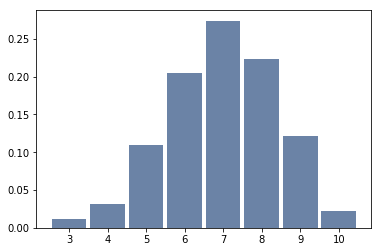

In [8]:
sample = [game_day(10, 0.7) for i in range(1000)]
pmf_sample = Pmf(sample)
thinkplot.Hist(pmf_sample)

The second method is convolution.  Instead of flipping a coin, we can create a `Pmf` object that represents the distribution of outcomes from a single flip.

In [9]:
def coin(p):
    return Pmf({1:p, 0:1-p})

Here's what it looks like.

In [10]:
player = coin(0.7)
player.Print()

0 0.30000000000000004
1 0.7


If we have two players, there are three possible outcomes:

In [11]:
(player + player).Print()

0 0.09000000000000002
1 0.42000000000000004
2 0.48999999999999994


If we have 10 players, we can get the prior distribution like this:

In [12]:
prior = sum([player]*10)
prior.Print()

0 5.9049000000000085e-06
1 0.00013778100000000018
2 0.0014467005000000017
3 0.009001692000000009
4 0.036756909000000025
5 0.10291934520000004
6 0.20012094900000005
7 0.26682793200000005
8 0.2334744405
9 0.12106082099999994
10 0.028247524899999984


Now we can compare the results of simulation and convolution:

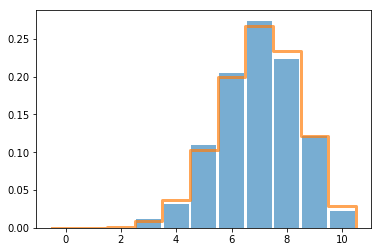

In [13]:
thinkplot.Hist(pmf_sample, color='C0')
thinkplot.Pmf(prior, color='C1')

Finally, we can use an analytic distribution.  The distribution we just computed is the [binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution), which has the following PMF:

$ PMF(k; n, p) = P(k ~|~ n, p) = {n \choose k}\,p^{k}(1-p)^{n-k}$

We could evalate the right hand side in Python, or use `MakeBinomialPmf`:



In [14]:
help(thinkbayes2.MakeBinomialPmf)

Help on function MakeBinomialPmf in module thinkbayes2.thinkbayes2:

MakeBinomialPmf(n, p)
    Evaluates the binomial PMF.
    
    Returns the distribution of successes in n trials with probability p.



And we can confirm that the analytic result matches what we computed by convolution.

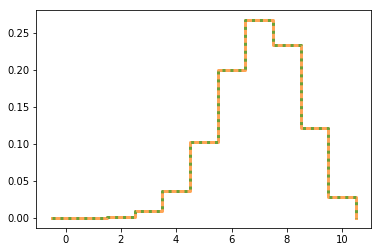

In [15]:
binomial = thinkbayes2.MakeBinomialPmf(10, 0.7)
thinkplot.Pmf(prior, color='C1')
thinkplot.Pmf(binomial, color='C2', linestyle='dotted')


### Likelihood

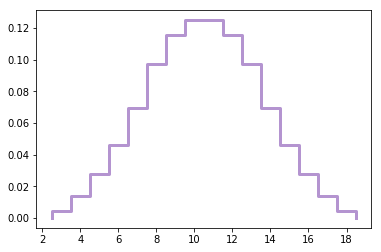

In [16]:
dice_pmf = Pmf([1,2,3,4,5,6])
all_dice = sum([dice_pmf]*3)
thinkplot.Pmf(all_dice, color='C4')

0.9814814814814815 0.9814814814814815


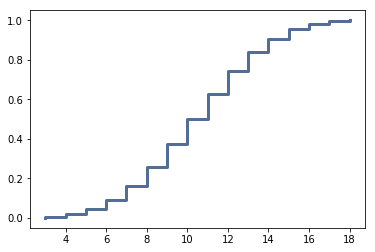

In [17]:
dice_cdf = Cdf(all_dice)
thinkplot.Cdf(dice_cdf)
lowest_five = 1-dice_cdf.Prob(4)
highest_xteen = dice_cdf.Prob(16)
print(lowest_five,highest_xteen)

In [18]:
dice_pmf = dice_cdf.MakePmf()
dice_pmf

Pmf({3: 0.00462962962962963, 4: 0.013888888888888892, 5: 0.02777777777777778, 6: 0.0462962962962963, 7: 0.06944444444444446, 8: 0.09722222222222224, 9: 0.11574074074074076, 10: 0.12500000000000006, 11: 0.125, 12: 0.1157407407407407, 13: 0.09722222222222221, 14: 0.06944444444444442, 15: 0.04629629629629628, 16: 0.02777777777777779, 17: 0.01388888888888884, 18: 0.00462962962962965})

In [19]:
dice_pmf[16]

0.02777777777777779

In [20]:
dice_pmf[5]

0.02777777777777778

In [21]:
def likelihood(players):
    # need to get 16 once and 5 once and then every other player must get in numbers
    like = (dice_pmf[16] * dice_pmf[5] * (lowest_five * highest_xteen) ** (4 + 6*(1-players)))
    return like

In [22]:
game = BayesTable([1,2,3,4,5,6,7,8,9,10], [prior[1],prior[2],prior[3],prior[4],prior[5],prior[6],prior[7],prior[8],prior[9],prior[10]])
game.likelihood = [0,0,likelihood(3),likelihood(4),likelihood(5),likelihood(6),likelihood(7),likelihood(8),likelihood(9),likelihood(10)]
game.update()
game

,hypo,prior,likelihood,unnorm,posterior
0,1,0.000138,0.000000,0.000000,0.000000
1,2,0.001447,0.000000,0.000000,0.000000
2,3,0.009002,0.001041,0.000009,0.003489
3,4,0.036757,0.001302,0.000048,0.017827
4,5,0.102919,0.001630,0.000168,0.062466
5,6,0.200121,0.002040,0.000408,0.152003
6,7,0.266828,0.002552,0.000681,0.253633
7,8,0.233474,0.003194,0.000746,0.277734
8,9,0.121061,0.003997,0.000484,0.180222
9,10,0.028248,0.005002,0.000141,0.052626


Likely 7 people showed up

# Rain in Seattle

You're about to get on a plane to Seattle. You want to know  if you should bring an umbrella. You call 3 random friends of yours who live there and ask each independently if it's raining. Each of your friends has a 2/3 chance of telling you the truth and a 1/3 chance of messing with you by lying. All 3 friends tell you that "Yes" it is raining. What is the probability that it's actually raining in Seattle?

In [23]:
rain = BayesTable(['Raining given Yes', 'Not Raining given Yes'])
rain.likelihood = [2/3**3, 1/3**3]
rain.update()
rain

,hypo,prior,likelihood,unnorm,posterior
0,Raining given Yes,1,0.074074,0.074074,0.666667
1,Not Raining given Yes,1,0.037037,0.037037,0.333333


# Cat Allergy Problem

Suppose you are having a dinner party with 10 guests and 4 of them are allergic to cats. Because you have cats, you expect 50% of the allergic guests to sneeze during dinner. At the same time, you expect 10% of the non-allergic guests to sneeze. What is the distribution of the total number of guests who sneeze?

Think of the three ways we have seen to compute distributions: simulation, convolution, and analysis.  Consider solving this problem all three ways.

Note: this is a forward probability problem; you are given the parameters of the system and asked to compute the distribution of outcomes.

The next problem is a inverse probability problem: you are given an outcome (data) and asked to infer the parameters of the system.


In [24]:
sneezes_allergic = [flip(0.5) for i in range(4)]
sneezes_other = [flip(0.1) for i in range(6)]
total_sneezes = sum(sneezes_allergic) + sum(sneezes_other)

In [25]:
def dinner_party(n_a,n_o, p_a, p_o):
    allergic = [flip(p_a) for i in range(n_a)]
    other = [flip(p_o) for i in range(n_o)]
    return sum(allergic) + sum(other)

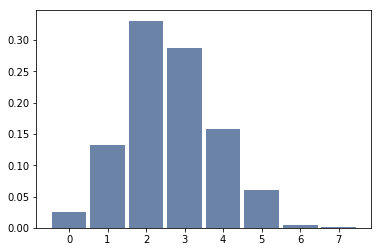

In [26]:
party = [dinner_party(4,6, 0.5, 0.1) for i in range(1000)]
pmf_party = Pmf(party)
thinkplot.Hist(pmf_party)

In [27]:
def guest(p):
    return Pmf({1:p, 0:1-p})

In [28]:
allergic_guest = coin(0.5)
allergic_guest.Print()
other_guest = coin(0.1)
other_guest.Print()

0 0.5
1 0.5
0 0.9
1 0.1


In [29]:
dinner_party = sum([allergic_guest]*4) + sum([other_guest]*6)
dinner_party.Print()

0 0.03321506250000001
1 0.15500362500000003
2 0.2940148125000001
3 0.29123550000000004
4 0.16241512500000005
5 0.05252175000000001
6 0.010265125000000002
7 0.0012355000000000005
8 8.981250000000002e-05
9 3.625000000000001e-06
10 6.250000000000002e-08


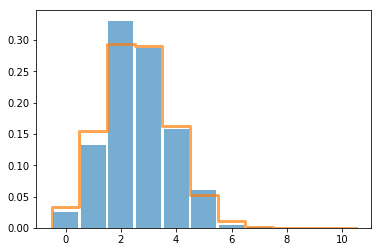

In [30]:
thinkplot.Hist(pmf_party, color='C0')
thinkplot.Pmf(dinner_party, color='C1')

# The Gluten Problem

"We studied 35 non-CD subjects (31 females) that were on a gluten-free diet (GFD), in a double-blind challenge study. Participants were randomised to receive either gluten-containing ﬂour or gluten-free ﬂour for 10 days, followed by a 2-week washout period and were then crossed over. The main outcome measure was their ability to identify which ﬂour contained gluten.

"The gluten-containing flour was correctly identiﬁed by 12 participants (34%)..."


Since 12 out of 35 participants were able to identify the gluten flour, the authors conclude "Double-blind gluten challenge induces symptom recurrence in just one-third of patients fulﬁlling the clinical diagnostic criteria for non-coeliac gluten sensitivity."

This conclusion seems odd to me, because if none of the patients were sensitive to gluten, we would expect some of them to identify the gluten flour by chance.  So the results are consistent with the hypothesis that none of the subjects are actually gluten sensitive.

Use the data from this study to estimate the number of patients who are actually sensitive to gluten.

To answer this question, you need some additional information, and you have to make some modelling assumptions:

1) Of the 35 subjects, 12 identified the gluten flour based on resumption of symptoms while they were eating it.  Another 17 subjects wrongly identified the gluten-free flour based on their symptoms, and 6 subjects were unable to distinguish.  So each subject gave one of three responses.  To keep things simple you can follow the authors of the study and lump together the second two groups; that is, consider two groups: those who identified the gluten flour and those who did not.

2) Let's assume that people who are actually gluten sensitive have a 95% chance of correctly identifying gluten flour under the challenge conditions, and subjects who are not gluten sensitive have only a 40% chance of identifying the gluten flour by chance (and a 60% chance of either choosing the other flour or failing to distinguish).


In [32]:
test = BayesTable(['Identified and Allergic', 'Identified and Not', 'Not and Allergic', 'Not and Not'], [12/35, 12/35, 23/35, 23/35])
test.likelihood = [0.95, 0.4, 0.05, 0.6]
test.update()
test

,hypo,prior,likelihood,unnorm,posterior
0,Identified and Allergic,0.342857,0.95,0.325714,0.365971
1,Identified and Not,0.342857,0.40,0.137143,0.154093
2,Not and Allergic,0.657143,0.05,0.032857,0.036918
3,Not and Not,0.657143,0.60,0.394286,0.443018


In [33]:
number_people = (0.37 * 35) + (0.04 * 35)
number_people

14.35

# The Height Problem

1) For adult male residents of the US, the mean and standard deviation of height are 178 cm and 7.7 cm.  For adult female residents the corresponding stats are 163 cm and 7.3 cm.  Suppose you learn that someone is 170 cm tall.  What is the probability that they are male?  

Note: We will have to discuss how to handle the likelihood function in this case, which is the PDF of the Gaussian distribution.

2) Run this analysis again for a range of observed heights from 150 cm to 200 cm, and plot a curve that shows P(male) versus height.  What is the mathematical form of this function?

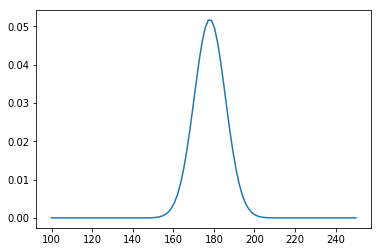

In [34]:
# standard deviation squared is variance
#
m_m = 178
m_std = 7.7
x=np.linspace(100, 250, 100)
m_pdf = stats.norm.pdf(x,m_m,m_std)
l1,=plt.plot(x,m_pdf, label='PDF')

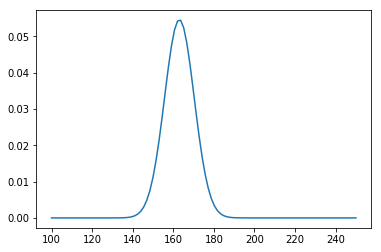

In [35]:
f_m = 163
f_std = 7.3
x=np.linspace(100, 250, 100)
f_pdf = stats.norm.pdf(x,f_m,f_std)
l2,=plt.plot(x,f_pdf, label='PDF')

In [52]:
f_cdf= stats.norm.cdf(170.5, 163, 7.3) - stats.norm.cdf(169.5, 163, 7.3)
m_cdf = stats.norm.cdf(170.5, 178, 7.7) - stats.norm.cdf(169.5, 178, 7.7)
print(f_cdf, m_cdf)
# nearly the same as the pdf - same idea - the cummulative from high point subtracted from the low

0.034505909513877664 0.030202716789350326


In [53]:
m_1 = stats.norm.pdf(170,178,7.7)
f_1 = stats.norm.pdf(170,163,7.3)

In [54]:
height2 = BayesTable(['Male', 'Female'], [1,1])
height2.likelihood = [m_1,f_1]
height2.update()
height2

,hypo,prior,likelihood,unnorm,posterior
0,Male,1,0.030201,0.030201,0.46672
1,Female,1,0.034508,0.034508,0.53328


In [65]:
prob_males = []
prob_female = []
values = list(range(150,200,1))
def prob_male(value):
    m_3 = stats.norm.pdf(value, 178, 7.7)
    f_3 = stats.norm.pdf(value, 163, 7.3)
    male = m_3/(m_3 + f_3)
    female = f_3/(m_3+f_3)
    return [male, female]
for i in values:
    prob_males.append(prob_male(i)[0])
    prob_female.append(prob_male(i)[1])


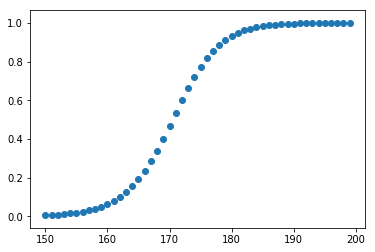

In [66]:
plt.scatter(values, prob_males)

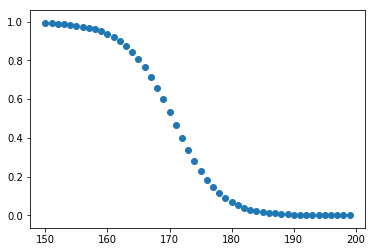

In [67]:
plt.scatter(values, prob_female)

This looks similar to a sigmoid graph or an "s" between 0 and 1 - which is the probability. 

# The Smoker Problem

According to the CDC, about 14% of adult women in the US smoke (and 18% of men).  According to an older report, also from the CDC, ``Compared to nonsmokers, men who smoke are about 23 times more likely to develop lung cancer and women who smoke are about 13 times more likely.''

If you learn that a woman has been diagnosed with lung cancer, and you know nothing else about her, what is the probability that she is a smoker?

In [74]:
smoker = BayesTable(['Female Smoker w/ Cancer', 'Female Non-Smoker w/'], [.14,.86])
smoker.likelihood = [13, 1]
smoker.update()
smoker

,hypo,prior,likelihood,unnorm,posterior
0,Female Smoker w/ Cancer,0.14,13,1.82,0.679104
1,Female Non-Smoker w/,0.86,1,0.86,0.320896
